In [1]:
#First out imports
#Lets import some stuff!
from datetime import datetime
import os

import cartopy
import matplotlib.pyplot as plt
from netCDF4 import num2date
import numpy as np
import pyart
import netCDF4
import xarray
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cmac import cmac, quicklooks
import copy
import importlib
import pytz

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def plot_radar_ppi(radar, field='reflectivity', cmap=None,
                   vmin=None, vmax=None, sweep=None, fig=None, name=None):
    if sweep is None:
        sweep = 0

    if name is None:
        name = 'KAMX'

    # Lets get some geographical context
    lats = radar.gate_latitude
    lons = radar.gate_longitude

    min_lon = lons['data'].min()
    min_lat = lats['data'].min()
    max_lat = lats['data'].max()
    max_lon = lons['data'].max()

    print('min_lat:', min_lat, ' min_lon:', min_lon,
          ' max_lat:', max_lat, ' max_lon:', max_lon)

    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = netCDF4.num2date(radar.time['data'][index_at_start],
                                              radar.time['units'])
    GMT = pytz.timezone('Australia/Darwin')
    local_time = GMT.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    print(fancy_date_string)
    if fig is None:
        fig = plt.figure(figsize=[15, 10])
    display = pyart.graph.RadarMapDisplayCartopy(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]

    # Main difference! Cartopy forces you to select a projection first!
    projection = cartopy.crs.Mercator(
        central_longitude=lon_0,
        min_latitude=min_lat, max_latitude=max_lat)

    title = name + ' ' + field.replace('_', ' ') + ' \n' + fancy_date_string

    display.plot_ppi_map(
        field, sweep, colorbar_flag=False,
        title=title,
        projection=projection,
        min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
        vmin=vmin, vmax=vmax, cmap=cmap, resolution='50m')

    lb = display._get_colorbar_label(field)
    cb = plt.colorbar(display.plots[0], shrink=.7, aspect=30, pad=0.01)
    cb.set_label(lb)
    # Mark the radar
    display.plot_point(lon_0, lat_0, label_text=name)

    # Plot some lat and lon lines
    gl = display.ax.gridlines(draw_labels=True,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False



In [3]:
radar_codes = importlib.import_module('processing_codes.radar_codes')
atten_codes = importlib.import_module('processing_codes.atten_codes')
#radar_codes = importlib.import_module('processing_codes.radar_codes')
#radar_codes = importlib.import_module('processing_codes.radar_codes')


In [4]:
indir = '/data/cpol_issue/'
all_files = os.listdir(indir)
test_file = indir + all_files[20]

In [5]:
radar = pyart.io.read(test_file)

In [6]:
print(radar.fields.keys())

dict_keys(['DBZ', 'VEL', 'WIDTH', 'ZDR', 'PHIDP', 'RHOHV'])


In [22]:
pyart.correct.phase_proc_lp?

In [25]:
#Dodheville
kdp_top = 5000.
coh_pwr = copy.deepcopy(radar.fields['PHIDP'])
coh_pwr['data'] = coh_pwr['data']*0.+1.
radar.fields['NCP'] = coh_pwr
phidp,kdp = pyart.correct.phase_proc_lp(radar,0.0,
                                      refl_field='DBZ',
                                      LP_solver='cylp',
                                      ncp_field='NCP',
                                      rhv_field='RHOHV',
                                      phidp_field='PHIDP',
                                      fzl = kdp_top,
                                      debug=True, min_rhv=.98)
radar.fields['cylp_processed_phase_98'] = phidp
radar.fields['specific_differential_phase'] = kdp

Unfolding


/home/scollis/anaconda3/envs/pyart3x/lib/python3.6/site-packages/pyart/correct/phase_proc.py:188: RuntimeWarning: invalid value encountered in sqrt
  noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
/home/scollis/anaconda3/envs/pyart3x/lib/python3.6/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / noise


Exec time:  18.490943431854248
Doing  0


/home/scollis/anaconda3/envs/pyart3x/lib/python3.6/site-packages/pyart/correct/phase_proc.py:589: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  sct[np.where(sct < 0.0)] = 0.0


Doing  1
Doing  2
Doing  3
Doing  4
Doing  5
Doing  6
Doing  7
Doing  8
Doing  9
Doing  10
Doing  11
Doing  12
Doing  13
Doing  14
Doing  15


min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


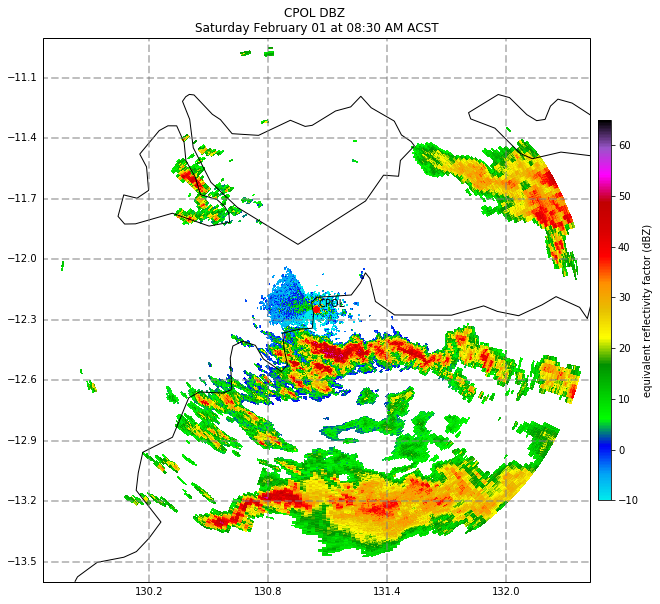

In [52]:
plot_radar_ppi(radar, field='DBZ', name='CPOL', sweep=1)
plt.savefig('/home/scollis/arm_projects/bom_visit_2017/images/z_test.png')

min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


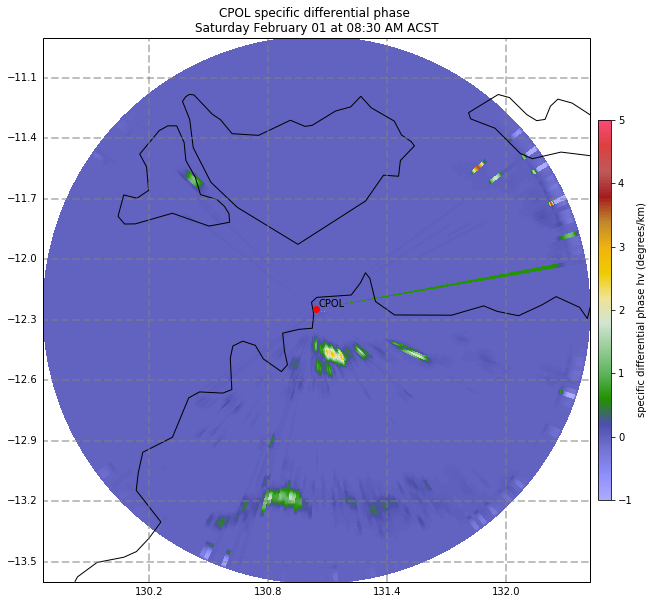

In [27]:
plot_radar_ppi(radar, field='specific_differential_phase', vmin=-1, vmax=5, sweep=1, name='CPOL')
plt.savefig('/home/scollis/arm_projects/bom_visit_2017/images/KDP_test.png')

min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


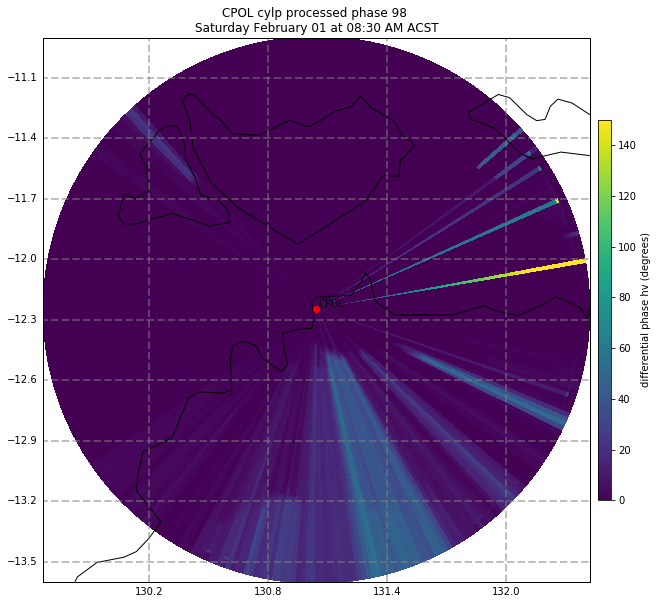

In [26]:
plot_radar_ppi(radar, field='cylp_processed_phase_98', vmin=0, vmax=150, sweep=1, name='CPOL')

min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


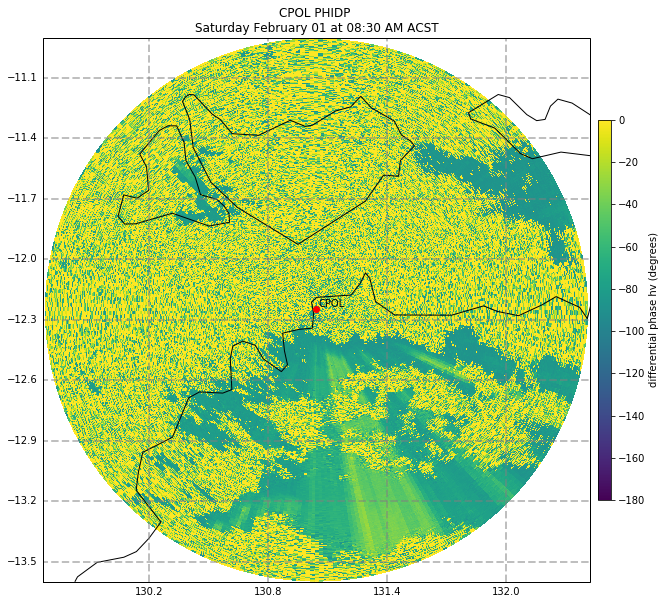

In [21]:
plot_radar_ppi(radar, field='PHIDP', vmin=-180, vmax=0, sweep=1, name='CPOL')

In [11]:
height, temperature, snr = radar_codes.snr_and_sounding(radar, '/data/cpol_issue/soundings/')
radar.add_field('temperature', temperature, replace_existing=True)
radar.add_field('height', height, replace_existing=True)
radar.add_field('SNR', snr, replace_existing=True)

In [12]:
rho_corr = radar_codes.correct_rhohv(radar)
radar.add_field_like('RHOHV', 'RHOHV_CORR', rho_corr, replace_existing=True)

In [13]:
fake_rhohv = False
gatefilter = radar_codes.do_gatefilter(radar, rhohv_name='RHOHV_CORR', is_rhohv_fake=fake_rhohv)

In [14]:
phidp_gg, kdp_gg = radar_codes.phidp_giangrande(radar, gatefilter)



/home/scollis/anaconda3/envs/pyart3x/lib/python3.6/site-packages/pyart/correct/phase_proc.py:188: RuntimeWarning: invalid value encountered in sqrt
  noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
/home/scollis/anaconda3/envs/pyart3x/lib/python3.6/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / noise
/home/scollis/anaconda3/envs/pyart3x/lib/python3.6/site-packages/pyart/correct/phase_proc.py:589: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  sct[np.where(sct < 0.0)] = 0.0


In [15]:
radar.add_field('PHIDP_GG', phidp_gg, replace_existing=True)
radar.add_field('KDP_GG', kdp_gg, replace_existing=True)
radar.fields['PHIDP_GG']['long_name'] = "corrected_differential_phase"
radar.fields['KDP_GG']['long_name'] = "corrected_specific_differential_phase"


min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


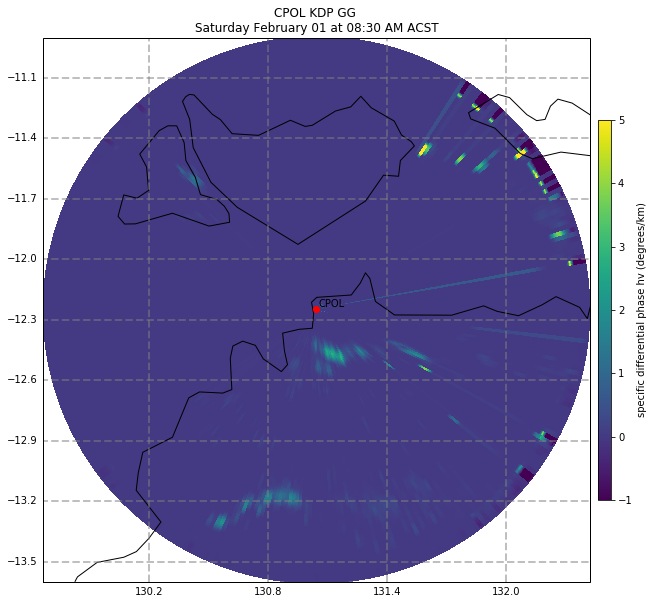

In [16]:
plot_radar_ppi(radar, field='KDP_GG', vmin=-1, vmax=5, sweep=1, name='CPOL')
plt.savefig('/home/scollis/arm_projects/bom_visit_2017/images/KDP_vl_test.png')

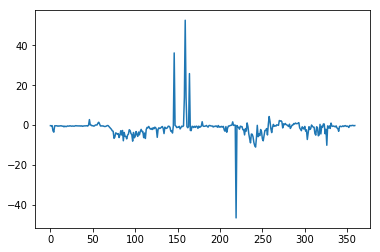

In [30]:
plt.plot(radar.fields['cylp_processed_phase_98']['data'][0:360,1])

min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


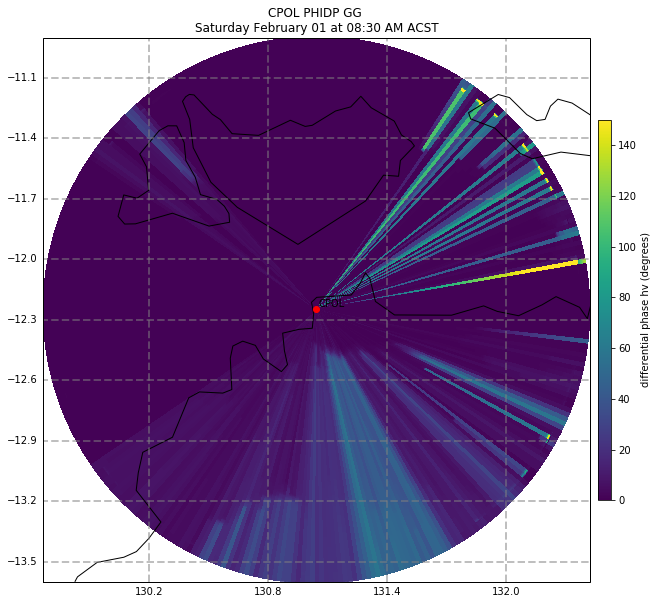

In [29]:
plot_radar_ppi(radar, field='PHIDP_GG', vmin=0, vmax=150, sweep=1, name='CPOL')